In [454]:
import numpy as np
import qml
import unittest
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
import collections

In [545]:
class Networker():
    def __init__(self, filename, nBN):
        self._c = qml.Compound(filename)
        self._atoms = np.where(self._c.nuclear_charges == 6)[0]
        self._g = nx.Graph()
        self._evaluated = []
        self._add_all_permutations(nBN)
    
    def _add_all_permutations(self, nBN):
        charges = np.zeros(len(self._atoms)) + 6
        charges[:nBN] = 5
        charges[nBN:2*nBN] = 7
        for target in it.permutations(tuple(charges)):
            self._add_node(tuple(target))
    
    def _format_label(self, n):
        return ''.join([str(int(_)) for _ in n])
    
    def _add_node(self, n1):
        self._g.add_node(n1)
    
    def _add_edge(self, n1, n2):
        self._g.add_edge(n1, n2)
    
    def get_similarity(self, nuclear_charges):
        """ Returns i, j, distance."""
        charges = self._c.nuclear_charges.copy().astype(np.float)
        charges[self._atoms] = nuclear_charges
        atoms = np.where(self._c.nuclear_charges == 6)[0]
        a = qml.representations.generate_coulomb_matrix(charges, self._c.coordinates, size=self._c.natoms, sorting='unsorted')
        s = np.zeros((self._c.natoms, self._c.natoms))
        s[np.tril_indices(self._c.natoms)] = a
        d = np.diag(s)
        s += s.T
        s[np.diag_indices(self._c.natoms)] = d
        sorted_elements = [np.sort(_) for _ in s[atoms]]
        ret = []
        for i in range(len(atoms)):
            for j in range(i+1, len(atoms)):
                dist = np.linalg.norm(sorted_elements[i] - sorted_elements[j])
                ret.append([atoms[i], atoms[j], dist])
        return ret, atoms
    
    def identify_equivalent(self, nuclear_charges):
        """ Returns groups of equivalent sites. """
        similarities, relevant = self.get_similarity(nuclear_charges)
        groups = []
        placed = []
        for i, j, dist in similarities:
            if dist > 3:
                continue
            for gidx, group in enumerate(groups):
                if i in group:
                    if j not in group:
                        groups[gidx].append(j)
                        placed.append(j)
                    break
                if j in group:
                    if i not in group:
                        groups[gidx].append(i)
                        placed.append(i)
                    break
            else:
                groups.append([i,j])
                placed += [i, j]
        for isolated in set(relevant) - set(placed):
            groups.append([isolated])
        return groups

    def get_coordinates(self):
        relevant = np.where(self._c.nuclear_charges == 6)[0]
        coords = self._c.coordinates[relevant, :2]
        coords -= np.mean(coords, axis=0)
        return coords
    
    def find_relations(self):
        for origin in self._g.nodes:
            for opposite in references_from_target(self, origin):
                self._add_node(tuple(opposite))
                self._add_edge(tuple(origin), tuple(opposite))
    
    def get_labels(self):
        return {_: self._format_label(_) for _ in self._g.nodes}
    
    def remove_spatial_symmetry_molecules(self):
        # make connected components smaller
        removed = []
        for component in nx.connected.connected_components(self._g):
            kept = []
            for node in component:
                if len(kept) == 0:
                    kept.append(node)
                    continue
                
                for k in kept:
                    sim = self.get_molecule_similarity(k, node)
                    if sim > 0.99999:
                        removed.append((node, k))
                        break
                else:
                    kept.append(node)
        for node, kept in removed:
            # transfer all connections from node to kept
            for neighbor in self._g.neighbors(node):
                self._add_edge(neighbor, kept)
            
            # delete node
            self._g.remove_node(node)
    
    def get_molecule_similarity(self, c1, c2):
        charges = self._c.nuclear_charges.copy()
        charges[self._atoms] = c1
        r1 = qml.fchl.generate_representation(self._c.coordinates, charges, self._c.natoms)
        charges = self._c.nuclear_charges.copy()
        charges[self._atoms] = c2
        r2 = qml.fchl.generate_representation(self._c.coordinates, charges, self._c.natoms)
        return qml.fchl.get_global_kernels(np.array([r1]), np.array([r2]), np.array([2])).flatten()[0]
        

In [131]:
## Tests
class TestNetworker(unittest.TestCase):
    def _run_test(self, zs, expected):
        n = Networker("../../test/benzene.xyz")
        actual = n.identify_equivalent(zs)
        self.assertEqual(actual, expected)
        
    def test_all_identical(self):
        self._run_test(np.array([6,6,6,6,6,6]), [[0, 1, 2, 3, 4, 5]])
        
    def test_one_different(self):
        self._run_test(np.array([6,6,6,6,6,5]), [[0, 4], [1, 3], [2], [5]])
        
    def test_fractional(self):
        self._run_test(np.array([6,6,6,6,6,5.5]),[[0, 4], [1, 3], [2], [5]])
        
    def test_fractional_groups(self):
        self._run_test(np.array([6,6,6,6,5.9,5.9]),[[0, 3], [1, 2], [4, 5]])
    
    def test_common_ground_same_group(self):
        result = check_common_ground(np.array([5,7,6,6,6,6]), np.array([7,5,6,6,6,6]), np.array([6,6,6,6,6,6]), [[0, 1], [2], [3], [4], [5]])
        self.assertTrue(result)
        
    def test_common_ground_separate_group(self):
        result = check_common_ground(np.array([5,7,5,7,6,6]), np.array([7,5,7,5,6,6]), np.array([6,6,6,6,6,6]), [[0, 1], [2, 3], [4], [5]])
        self.assertTrue(result)
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_all_identical (__main__.TestNetworker) ... ok
test_common_ground_same_group (__main__.TestNetworker) ... ok
test_common_ground_separate_group (__main__.TestNetworker) ... ok
test_fractional (__main__.TestNetworker) ... ok
test_fractional_groups (__main__.TestNetworker) ... ok
test_one_different (__main__.TestNetworker) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.102s

OK


In [391]:
def targets_from_reference(reference):
    pass
def check_common_ground(target, opposite, reference, common_ground):
    deltaZ = opposite - target
    
    # matching deltaZ
    values, counts = np.unique(deltaZ, return_counts=True)
    counts = dict(zip(values, counts))
    
    for value in values:
        if value == 0:
            continue
        if -value not in counts:
            return False
        if counts[-value] != counts[value]:
            return False
    
    # ignore id operation
    if max(np.abs(deltaZ)) == 0:
        return False
    
    # all changing atoms need to be in the same group
    assigned = []
    for value in values:
        if value <= 0:
            continue
            
        changed_pos = np.where(deltaZ == value)[0]
        changed_neg = np.where(deltaZ == -value)[0]
        for changed in changed_pos:
            for group in common_ground:
                if changed in group:
                    break
            else:
                raise ValueError("should not happen")
            partners = set(changed_neg).intersection(set(group)) - set(assigned)
            if len(partners) == 0:
                return False
            assigned.append(next(iter(partners)))
            assigned.append(changed)
    return True
    
def references_from_target(networker, target):
    target = np.array(target)
    
    # get all possible opposite targets
    candidates = set([_ for _ in it.permutations(target)])
    #candidates = PERMUTATIONS
    #candidates = [np.array(_) for _ in candidates]
    
    found = []
    for opposite in candidates:
        reference = (opposite + target) / 2
        common_ground = networker.identify_equivalent(reference)
        if check_common_ground(target, opposite, reference, common_ground):
            #found.append((reference, opposite))
            found.append(opposite)
    return found

In [546]:
n = Networker("../../test/benzene.xyz", nBN=2)
n.find_relations()
n.remove_spatial_symmetry_molecules()

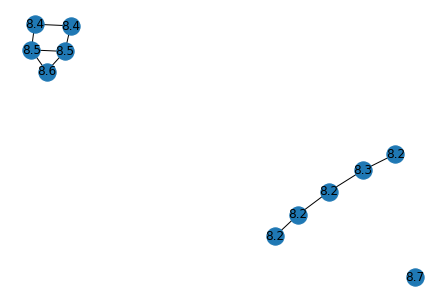

In [569]:
pos=nx.spring_layout(n._g)
nx.draw(n._g, pos=pos)
labels={_: str(get_energy(_))[3:6] for _ in n._g.nodes}
_ = nx.draw_networkx_labels(n._g, pos=pos, labels=labels)

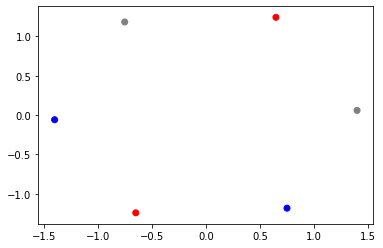

In [338]:
coords = n.get_coordinates()
lookup = {6: 'grey', 5:'red', 7:'blue'}
zs = (6,5,6,7,5,7)
plt.scatter(coords[:, 0], coords[:, 1], color=[lookup[_] for _ in zs])

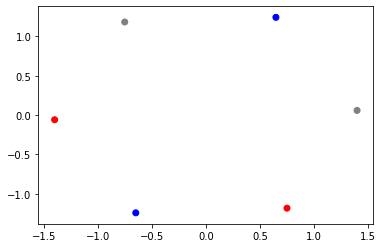

In [339]:
coords = n.get_coordinates()
lookup = {6: 'grey', 5:'red', 7:'blue'}
zs = (6, 7, 6, 5, 7, 5)
plt.scatter(coords[:, 0], coords[:, 1], color=[lookup[_] for _ in zs])

In [427]:
# other distance metric?
# other cutoff for similarity?
# how many cases of alchemical symmetry in benyene?
# kein qml sondern delta V aehnlichkeit
# very loose cutoff: all nBN same energy - how good is that?

# apparently any symmetry op as alchemical reflection 


In [575]:
def bond_count(mol):
    a = list(mol)
    b = a[1:]+a[:1]
    bonds = {}
    c = collections.Counter()
    for z1, z2 in zip(a, b):
        if z2 > z1:
            z1, z2 = z2, z1
        c.update([(z1, z2)])
    # H needed, but always the same in same BN pair benzene
    #for z in mol:
    #    c.update([(z, 1)])
    return c

#https://www.physik.uzh.ch/groups/osterwalder/zz_publications_old/cm034805s.pdf
def bond_energy(counts):
    return counts[(7., 6.)]*305./4 + counts[(7., 7.)]*160./4 + counts[(7., 5.)]*115 + counts[(6., 6.)]*346./4 + counts[(6., 5.)]*356./4 
def order(g):
    pass
    # find clusters
    # establish inequalities for bonds
    # assume all clusters same electronic energy
    # sort clusters by inequalities

In [544]:
def get_NN(n, mol):
    def nuclei_nuclei(coordinates, charges):
        angstrom = 1 / 0.52917721067
        natoms = len(coordinates)
        ret = 0.0
        for i in range(natoms):
            for j in range(i + 1, natoms):
                d = np.linalg.norm((coordinates[i] - coordinates[j]) * angstrom)
                ret += charges[i] * charges[j] / d
        return ret
    
    charges = n._c.nuclear_charges.copy()
    charges[:6] = mol
    return nuclei_nuclei(n._c.coordinates, charges)

get_NN(n, (5,5,5,7,7,7)), get_NN(n, (7,7,5,7,5,5)), get_NN(n, (7,5,7,5,7,5)), get_NN(n, (6,6,6,6,6,6)), 

(202.77164394773592,
 202.01519595134565,
 201.49276981191562,
 203.01930973521218)

In [542]:
a = (7,7,5,6,5,6)
b = (5,5,7,6,7,6)
bond_count(a)-bond_count(b), bond_count(b)-bond_count(a)

(Counter({(7, 7): 1, (6, 5): 2}), Counter({(5, 5): 1, (7, 6): 2}))

In [482]:
def lse(counters):
    combined = sum(counters, collections.Counter())
    nummols = len(counters)
    numbonds = len(combined)
    A = np.zeros((nummols, numbonds))
    for molidx, counter in enumerate(counters):
        A[molidx, :] = [counter[_] for _ in combined]
    return A
lse((bond_count((6,5,7,7,5,6)), bond_count((6,7,5,5,7,6))))

array([[2., 2., 1., 1., 0., 0.],
       [0., 2., 0., 1., 2., 1.]])

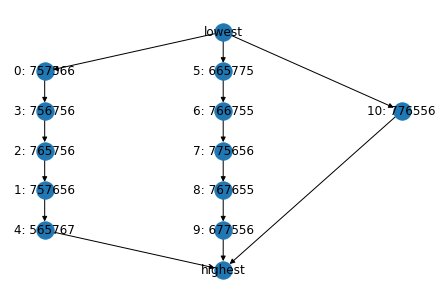

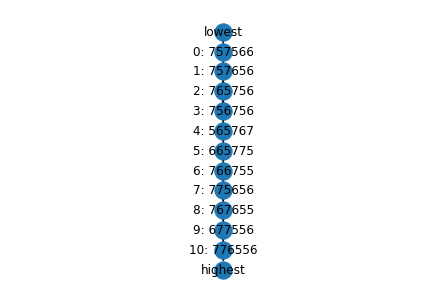

In [571]:
def visualise_order(n):
    order = nx.DiGraph()
    g = n._g
    ordered = list(g.nodes)
    ordered.sort(key=lambda _: get_energy(_) + get_NN(n, _))
    
    for component in nx.connected.connected_components(g):
        component = list(component)
        component.sort(key=lambda _: get_NN(n, _))
        
        order.add_edge('least', component[0])
        for n1, n2 in zip(component[:-1], component[1:]):
            order.add_edge(n1, n2)
        order.add_edge(component[-1], 'greatest')
    
    #pos=nx.planar_layout(order)
    pos = nx.nx_pydot.graphviz_layout(order, prog='dot', root='least')
    format_label = lambda n: ''.join([str(int(_)) for _ in n])
    labels = dict()
    for node in g.nodes:
        rank = ordered.index(node)
        labels[node] = '%d: %s' % (rank, format_label(node))
    
    labels['least'] = "lowest"
    labels['greatest'] = "highest"
    nx.draw(order, pos=pos)
    _ = nx.draw_networkx_labels(order, pos=pos, labels=labels)
    plt.show()
    
    # real reference
    real = nx.DiGraph()
    real.add_edge('least', ordered[0])
    for n1, n2 in zip(ordered[:-1], ordered[1:]):
        real.add_edge(n1, n2)
    real.add_edge(ordered[-1], 'greatest')
    pos = nx.nx_pydot.graphviz_layout(real, prog='dot', root='least')
    nx.draw(order, pos=pos)
    _ = nx.draw_networkx_labels(real, pos=pos, labels=labels)
    
        
visualise_order(n)

In [580]:
for component in nx.connected.connected_components(n._g):
    energies= []
    for node in component:
        energies.append(bond_energy(bond_count(node)))
        print (node, bond_count(node))
    print ("....", sum(energies) / len(energies))

(7.0, 5.0, 7.0, 6.0, 5.0, 6.0) Counter({(7.0, 5.0): 2, (7.0, 6.0): 2, (6.0, 5.0): 2})
(5.0, 6.0, 5.0, 7.0, 6.0, 7.0) Counter({(6.0, 5.0): 2, (7.0, 5.0): 2, (7.0, 6.0): 2})
(7.0, 5.0, 6.0, 7.0, 5.0, 6.0) Counter({(7.0, 5.0): 2, (6.0, 5.0): 2, (7.0, 6.0): 2})
(7.0, 5.0, 7.0, 5.0, 6.0, 6.0) Counter({(7.0, 5.0): 3, (6.0, 5.0): 1, (6.0, 6.0): 1, (7.0, 6.0): 1})
(7.0, 6.0, 5.0, 7.0, 5.0, 6.0) Counter({(7.0, 6.0): 2, (6.0, 5.0): 2, (7.0, 5.0): 2})
.... 567.75
(6.0, 7.0, 7.0, 5.0, 5.0, 6.0) Counter({(7.0, 6.0): 1, (7.0, 7.0): 1, (7.0, 5.0): 1, (5.0, 5.0): 1, (6.0, 5.0): 1, (6.0, 6.0): 1})
(7.0, 6.0, 7.0, 6.0, 5.0, 5.0) Counter({(7.0, 6.0): 3, (6.0, 5.0): 1, (5.0, 5.0): 1, (7.0, 5.0): 1})
(7.0, 7.0, 5.0, 6.0, 5.0, 6.0) Counter({(6.0, 5.0): 3, (7.0, 7.0): 1, (7.0, 5.0): 1, (7.0, 6.0): 1})
(6.0, 6.0, 5.0, 7.0, 7.0, 5.0) Counter({(6.0, 5.0): 2, (7.0, 5.0): 2, (6.0, 6.0): 1, (7.0, 7.0): 1})
(7.0, 6.0, 6.0, 7.0, 5.0, 5.0) Counter({(7.0, 6.0): 2, (7.0, 5.0): 2, (6.0, 6.0): 1, (5.0, 5.0): 1})
.... 468

In [559]:
ccsdenergies = {
(5,7,6,6,6,6): -436.447,
(5,6,7,6,6,6): -436.542,
(5,6,6,7,6,6): -436.581,
(5,7,6,5,7,6): -438.247,
(5,7,5,7,6,6): -438.258,
(5,7,5,6,7,6): -438.281,
(5,7,6,5,6,7): -438.286,
(5,7,6,7,5,6): -438.362,
(5,7,6,6,7,5): -438.401,
(5,7,7,5,6,6): -438.413,
(5,7,6,7,6,5): -438.542,
(5,7,7,6,5,6): -438.553,
(5,7,7,6,6,5): -438.673,
(5,6,7,7,6,5): -438.785,
(7,5,7,5,7,5): -439.998,
(5,7,5,7,7,5): -440.300,
(5,7,7,7,5,5): -440.806}
def get_energy(mol):
    for shift in range(6):
        if mol in ccsdenergies:
            return ccsdenergies[mol]
        mol = tuple(list(mol)[1:]+list(mol)[:1])
    return get_energy(tuple(list(mol)[::-1]))

In [560]:
[(_, get_energy(_)) for _ in n._g.nodes]

[((5.0, 6.0, 5.0, 7.0, 6.0, 7.0), -438.362),
 ((7.0, 5.0, 7.0, 5.0, 6.0, 6.0), -438.258),
 ((7.0, 5.0, 7.0, 6.0, 5.0, 6.0), -438.286),
 ((7.0, 5.0, 6.0, 7.0, 5.0, 6.0), -438.247),
 ((7.0, 7.0, 5.0, 6.0, 5.0, 6.0), -438.553),
 ((7.0, 7.0, 6.0, 5.0, 5.0, 6.0), -438.785),
 ((7.0, 6.0, 5.0, 7.0, 5.0, 6.0), -438.281),
 ((7.0, 6.0, 7.0, 6.0, 5.0, 5.0), -438.542),
 ((7.0, 6.0, 6.0, 7.0, 5.0, 5.0), -438.401),
 ((6.0, 7.0, 7.0, 5.0, 5.0, 6.0), -438.673),
 ((6.0, 6.0, 5.0, 7.0, 7.0, 5.0), -438.413)]

In [578]:
bond_count(node)[(7.0, 5.0)]

2